#Pre-processing

##Load data

In [ ]:
#connect to google dirve

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Load sample data (P1)
path='gdrive/My Drive/project/raw_data/'
ID='20946596'

import os
print(os.listdir(path+ID))

['ACTIVITY_20946596.csv', 'APP_RUNNING_20946596.csv', 'BATTERY_20946596.csv', 'RINGER_20946596.csv', 'SCREEN_20946596.csv', 'DATA_20946596.csv', 'GPS_20946596.csv', 'NOTIFICATION_20946596.csv', 'TOUCH_EVENT_20946596.csv', 'WIFI_20946596.csv', 'NOTIFICATION_20946596.gsheet']


We can easily check the types of data collected by individuals as follows, and the descriptions of the main categories are as follows.
![대체 텍스트](https://drive.google.com/uc?id=14Pp3iMcftmrJYZqUoXP83veoPo0CYcrH)

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df_noti=pd.read_csv(path+ID+"/NOTIFICATION_"+ID+".csv")
df_app=pd.read_csv(path+ID+"/APP_RUNNING_"+ID+".csv")
df_screen=pd.read_csv(path+ID+"/SCREEN_"+ID+".csv")
df_touch=pd.read_csv(path+ID+"/TOUCH_EVENT_"+ID+".csv")

In [ ]:
df_noti.head()

,timestamp,type,package,title,text,subtext,sound,vibrate,defaults,ledon,ledoff,ledrgb
0,2017.09.05_17.36.37,POSTED,com.kakao.talk,null,null,6개의 안 읽은 메시지,,null,0,0,0,0
1,2017.09.05_17.36.52,POSTED,android,키보드 변경,한국어 - LG 키보드,null,,null,0,0,0,0
2,2017.09.05_17.36.55,POSTED,com.kakao.talk,null,null,7개의 안 읽은 메시지,,null,0,0,0,0
3,2017.09.05_17.36.57,POSTED,com.kakao.talk,null,null,8개의 안 읽은 메시지,,null,0,0,0,0
4,2017.09.05_17.36.58,POSTED,android,키보드 변경,한국어 - LG 키보드,null,,null,0,0,0,0


In [ ]:
df_app.head()

,timestamp,package
0,2017.09.05_17.35.48.025,com.android.settingsaccessibility
1,2017.09.05_17.35.55.405,com.lge.signboard
2,2017.09.05_17.35.57.921,com.android.settings
3,2017.09.05_17.36.15.171,kaist.iclab.twiceburster
4,2017.09.05_17.36.37.840,com.lge.signboard


In [ ]:
df_screen.head()

,timestamp,screen
0,2017.09.05_17.44.35.000,screenOff
1,2017.09.05_17.44.36.000,screenOn
2,2017.09.05_17.44.47.000,screenOff
3,2017.09.05_17.49.20.000,screenOn
4,2017.09.05_17.50.06.000,screenOff


In [ ]:
df_touch.head()

,timestamp,event_type
0,2017.09.05_17.35.49.373,SCROLLTOUCH
1,2017.09.05_17.35.50.776,SCROLLTOUCH
2,2017.09.05_17.35.51.175,SCROLLTOUCH
3,2017.09.05_17.35.58.058,SCROLLTOUCH
4,2017.09.05_17.36.00.319,SHORTTOUCH


We looked at data related to user's interactions. They include app usage, notifications, touch, and screen events. But as we can see each data a different unit of time stamp (In the case of touch and app use, they are recorded up to milliseconds, but screens and notifications are only recorded up to seconds). This problem makes it difficult to define the session to be performed in the later because the sequential relationship of events cannot be grasped.![sequence of events](https://drive.google.com/uc?id=1StbmyBdX4_gGjK5yWGVnVY3lA185luFx)

##Sort data

In order to solve the above-mentioned problem, we proposed the following sorting rule.

1. When events were sorted, they are misaligned for events that occur within the same second due to the inconsistent timestamp unit.

2. Therefore, the following priorities are assigned to events that occur within the same second.

    Prioirty: Screen on < Notification events < app use and  touch envent < Screen off

In [ ]:
# Text-written timestamps make it difficult to convert to data time. Therefore, we can convert to seconds using customized functions.
def day(x):
    return x.split('_')[0]
def time_transform(x):
    x=x.split('_')[1].split('.')
    return int(x[0])*3600+int(x[1])*60+int(x[2])
def remove_space(x):
    if " " in x:
        x=x[1:]
    return x
# Also we assigned priorites to aggregated data
def Type_transform(x):
    if "screenOn" in x:
        return "screenOn"
    if "screenOff" in x:
        return "screenOff"
    if "com." in x:
        return "app"
    if "POSTED" in x:
        return "POSTED"
    if 'REMOVED' in x:
        return 'REMOVED'
    else:
        return "touch"
def priority(x):
    if x=='screenOn':
        return "A"
    elif x=='POSTED':
        return "B"
    elif x=='REMOVED':
        return "C"
    elif x=="app" or x=='touch':
        return "D"
    else:
        return "E"

In [ ]:
# Stores a sequence of original screen data
index=list(range(len(df_screen)))
index=pd.DataFrame({"index": index})
df_screen=pd.concat([df_screen,index], axis=1)

# Preparation for alignment
df_noti=df_noti.iloc[:,:2]
df_app=df_app.rename(columns = {' package': 'event'})
df_noti=df_noti.rename(columns={' type':'event'})
df_screen=df_screen.rename(columns = {' screen': 'event'})
df_touch=df_touch.rename(columns = {' event_type': 'event'})
    
df_app['index']=0
df_noti['index']=0
df_touch['index']=0
    
df_noti.iloc[:,0:1]=df_noti.iloc[:,0:1].applymap(remove_space)
df_app.iloc[:,0:1]=df_app.iloc[:,0:1].applymap(remove_space)
df_screen.iloc[:,0:1]=df_screen.iloc[:,0:1].applymap(remove_space)
df_touch.iloc[:,0:1]=df_touch.iloc[:,0:1].applymap(remove_space)
    
start=max([df_app['timestamp'][0],df_noti['timestamp'][0],df_screen['timestamp'][0], df_touch['timestamp'][0]])
end=min([df_app['timestamp'][len(df_app)-1], df_noti['timestamp'][len(df_noti)-1], df_screen['timestamp'][len(df_screen)-1], df_touch['timestamp'][len(df_touch)-1]])

# Aggregate dataset    
df=pd.concat([df_app,df_noti, df_screen, df_touch], ignore_index=True)
    
    
df['type']=df.iloc[:,1:2].applymap(Type_transform)
df['day']=df.iloc[:,0:1].applymap(day)
df['priority']=df.iloc[:,3:4].applymap(priority)
df['second']=df.iloc[:,0:1].applymap(time_transform)

# Sort data with each priorities    
df=df.sort_values(['day','second','priority',"timestamp"], ascending=[True,True, True, True])
df=df[(df['timestamp']>=start) & (df['timestamp']<=end)].reset_index(drop=True)
    
# Rearrange original screen data if it warps

prev=df['type'][0]
for i in range(1,len(df)):
    curr=df['type'][i]
    if (prev=='screenOn' or prev=='screenOff') and (curr=='screenOn' or curr=='screenOff'):
        if df['index'][i-1]>df['index'][i]:
            temp1=df['type'][i-1]
            df['type'][i-1]=df['type'][i]
            df['type'][i]=temp1

            temp2=df['event'][i-1]
            df['event'][i-1]=df['event'][i]
            df['event'][i]=temp2
    prev=curr

As a result, we could see that the sequence of the data was more natural.
![sorting result](https://drive.google.com/uc?id=1KK32LmBBoRomIQ-7536K0tskII8CLInL)

##Imputation

Smartphone-based continuous sensing and data recording may suffer from missing data due to resource limitation and optimization policies in mobile devices In this study, screen on/off events were paired in order to define smartphone usage sessions. However, we found that 8\% of screen-on events and 11\% of screen-off events were missing. We used a simple heuristic of imputing missing values by associating on and off events with touch interaction events (e.g., first touch or last touch). We simultaneously considered multiple data streams, i.e., screen-on/off, application, and touch/keyboard events to impute missing values.
![Imputation](https://drive.google.com/uc?id=17qz2yggnpiZZDGwg-e62n3bLP8rp33Pv)

In [ ]:
# Impute screenOn in case 1
for i in range(1,len(df)):
    curr=df['type'][i] 
    if (curr== 'app' or curr== 'touch') and prev=='screenOff':
        candidate=i
        start='Y'
        while True:
            if (df['second'][candidate+1]-df['second'][candidate]<=45 and df['second'][candidate+2]-df['second'][candidate+1]<=45):
                break
            else:
                candidate+=1
        prev=curr        
        continue

    if start=='Y' and curr=='screenOff':
        line = pd.DataFrame({'timestamp': df['timestamp'][candidate], "event":' screenOn', 'type':'screenOn',  'second':df['second'][candidate]} , index=[candidate])
        df = pd.concat([df.iloc[:candidate], line, df.iloc[candidate:]])
        df=df.reset_index(drop=True)
        start=None

    elif start=='Y' and curr=='screenOn':
        start=None
    prev=curr

# impute screenOff in case 2-1
prev=df['type'][0]
start=None
for i in range(1,len(df)):
    curr=df['type'][i] 
    if prev=='screenOff' and curr=="POSTED":
        start='Y'

    if start=='Y' and (prev=="screenOff" and curr=='screenOn'):
        start=None

    elif start=='Y' and ((prev=='touch' or prev=='app' or prev=='REMOVED') and curr=='screenOn'):
        candidate=i
        line = pd.DataFrame({'timestamp': df['timestamp'][candidate-1], "event":' screenOff', 'type':'screenOff',  'second':df['second'][candidate-1]} , index=[candidate])
        df = pd.concat([df.iloc[:candidate], line, df.iloc[candidate:]])
        df=df.reset_index(drop=True)
        start=None
    prev=curr

# impute screenOff in case 2-2
prev=df['type'][0]
start=None
for i in range(1,len(df)):
    curr=df['type'][i] 
    if prev=='screenOff' and curr=="POSTED":
        start='Y'

    if start=='Y' and (prev=="screenOff" and curr=='screenOn'):
        start=None

    elif start=='Y' and ((df['second'][i]-df['second'][i-1]>30) and (curr=='POSTED' or curr=="screenOn")):
        candidate=i
        line = pd.DataFrame({'timestamp': df['timestamp'][candidate-1], "event":' screenOff', 'type':'screenOff',  'second':df['second'][candidate-1]} , index=[candidate])
        df = pd.concat([df.iloc[:candidate], line, df.iloc[candidate:]])
        df=df.reset_index(drop=True)
        start=None
    prev=curr

After imputation, we could observe the missing case almost 0%
![Result](https://drive.google.com/uc?id=1oy47fOIaQuk37uGp66z3jSXG34TS6JyF)

##Extract in-class data

We needed to extract only class data to examine students' behavior in using smartphones in class. To do that, we used data from previous studies, you can refer to **"Understanding smartphone usage in college classrooms: A long-term measurement study"** paper for details. Briefly, it is as follows:


*   Wi-Fi fingerprints: Matching MAC address
*   GPS (If there is no Wi-Fi log):  Determined whether student's current location was within the building radius





In [ ]:
df_in_class

,classname,enterance_time,exit_time
0,일반화학2-B,2017.09.11_09.00.00,2017.09.11_10.15.00
1,OR개론-A,2017.09.11_13.00.00,2017.09.11_14.15.00
2,IntermediateEnglishReading&Writing-H,2017.09.11_14.32.54,2017.09.11_15.45.00
3,미적분학2-M&N,2017.09.12_13.00.00,2017.09.12_14.15.00
4,일반물리학2-E,2017.09.12_14.30.00,2017.09.12_15.45.00
...,...,...,...
86,미적분학2-M&N,2017.11.30_13.00.00,2017.11.30_14.15.00
87,일반물리학2-E,2017.11.30_14.30.00,2017.11.30_15.45.00
88,OR개론-A,2017.12.04_13.00.00,2017.12.04_14.15.00
89,IntermediateEnglishReading&Writing-H,2017.12.04_14.30.00,2017.12.04_15.45.00


In [ ]:
# load previous studies preprocessed data 
df=pd.read_csv('gdrive/My Drive/project/imputed_data/event_'+ID+'.csv', error_bad_lines=False)
df_in_class=pd.read_csv('gdrive/My Drive/project/class_app_usage/'+ID+'/Session_In_Class_'+ID+'.csv')
df_in_class=df_in_class.iloc[:,0:3]

# Remove duplicated data and sort by time stamp
df_in_class=df_in_class.drop_duplicates()
df_in_class.iloc[:,1:2]=df_in_class.iloc[:,1:2].applymap(remove_space)
df_in_class.iloc[:,2:]=df_in_class.iloc[:,2:].applymap(remove_space)
df_in_class=df_in_class.sort_values([" enterance_time"], ascending=[True]).reset_index(drop=True)

# Extract in-class data using previous extracted entrance and exit time
start_time=remove_space(df_in_class[' enterance_time'][0])
end_time=remove_space(df_in_class[' exit_time'][len(df_in_class)-1])
df=df[(df['timestamp']>=start_time) & (df['timestamp']<=end_time)].reset_index(drop=True)

for i in range(len(df_in_class)):
    start_time=df_in_class[' enterance_time'][i]
    end_time=df_in_class[' exit_time'][i]
    df.loc[(start_time <= df.timestamp) & (df.timestamp< end_time), 'classname']=df_in_class['classname'][i]
    
df=df.dropna(axis=0).reset_index(drop=True)
df=df.reindex(columns=['classname', 'timestamp', 'event', 'type'])

# Load  the app package that caused the notification using previous dataset
df_noti=pd.read_csv('gdrive/My Drive/project/class_app_usage/'+ID+'/NOTIFICATION_'+ID+'.csv', error_bad_lines=False)
df_noti['timestamp']=df_noti.iloc[:,1:2].applymap(remove_space)
time_list=list(df_noti['timestamp'])
df['second']=df.iloc[:,1:2].applymap(time_transform)
    
for i in range(len(df_noti)):
    df.loc[df_noti['timestamp'][i]==df.timestamp , 'app']=df_noti[' package'][i]

In [ ]:
df.head()

,classname,timestamp,event,type,second,app
0,일반화학2-B,2017.09.11_09.02.13.000,screenOn,screenOn,32533,NaN
1,일반화학2-B,2017.09.11_09.02.13.827,com.lge.launcher2,app,32533,NaN
2,일반화학2-B,2017.09.11_09.02.18.164,com.facebook.katana,app,32538,NaN
3,일반화학2-B,2017.09.11_09.02.18.746,SCROLLTOUCH,touch,32538,NaN
4,일반화학2-B,2017.09.11_09.02.19.403,SCROLLTOUCH,touch,32539,NaN


# Session Definition

We further divided the session in more detail based on how a user reacted to notifications, so that we could analyze how different reaction types were related to academic performance. 



![session](https://drive.google.com/uc?id=1k9fOCxvUSmIYp4aX-hB7iR1PzBHnRBk_)

In [ ]:
# Initialize variables to classify sessions
prev="screenOff"
prev_class=df['classname'][0]
app_list=[]
interaction_list=[]
start=[]
end=[]
session_time=[]
class_list=[]
Type_list=[]
app=0
interaction=0
User_session=None
Noti_session=None
Type=None
inter=None
noti_app=[]

for i in range(len(df)-1):
    curr=df['type'][i]
    curr_class=df['classname'][i]
    after=df['type'][i+1]


    if prev_class!=curr_class:
        prev='screenOff'
        app=0
        interaction=0
        User_session=None
        Noti_session=None
        Type=None
        noti_app=[]


# Store the app that caused notifications that arrived between inter sessions: 
# This is to differentiate between E_uu and I_uu sessions.
    if User_session==None :
        if df['type'][i]=="POSTED" and df['app'][i] not in noti_app:
            noti_app.append(df['app'][i])




# Session start: Whether the session was triggered by notification or not
    if prev=='screenOff' and curr=='screenOn':
        if after=='POSTED' and df['second'][i+1]-df['second'][i]<=1:
            Noti_session="Y"
            session_start=df['timestamp'][i]
        else:
            User_session='Y'
            session_start=df['timestamp'][i]


    elif prev=='screenOff' and curr=="POSTED":
            Noti_session="Y"
            session_start=df['timestamp'][i]


# E_uu Session and I_uu Session Classification: Determining if the first launched app was launched by a previously arrived notification
    if User_session=="Y":
        if Type==None:
            if curr=='app'  and ("launcher" not in df['event'][i] and "system"  not in df['event'][i] and 'signboard' not in df['event'][i]):
                if df['event'][i] in noti_app:
                    Type="E_uu"
                else:
                    Type="I_uu"

        if curr=='app' and  ("launcher" not in df['event'][i] and "system"  not in df['event'][i] and 'signboard' not in df['event'][i]):
            app+=1
        elif curr=="touch":
            interaction+=1

        elif curr=="screenOff":
            if Type==None:
                Type="I_uu"
            session_end=df['timestamp'][i]
            start.append(session_start)
            end.append(session_end)
            session_time.append(time_transform(session_end)-time_transform(session_start))
            app_list.append(app)
            interaction_list.append(interaction)
            class_list.append(df['classname'][i])
            Type_list.append(Type)
            User_session=None
            Type=None
            app=0
            interaction=0
            noti_app=[]

# Capture in-session behavior (number of app launches and touch and keyboard events) and classify the sessions according to the behaviors in the session
    if Noti_session=='Y':
        if curr=='app' and  ("launcher" not in df['event'][i] and "system"  not in df['event'][i] and 'signboard' not in df['event'][i]):
            app+=1
            if inter==None:
                session_start=df['timestamp'][i]
                inter="Y"
        elif curr=="touch":
            interaction+=1
            if inter==None:
                session_start=df['timestamp'][i]
                inter="Y"
        elif curr=="screenOff":
            if app==0 and interaction==0:
                Type="E_ig"
            elif app==0 and interaction!=0:
                Type="E_nl"
            else:
                Type="E_nu"
                noti_app=[]

            session_end=df['timestamp'][i]
            start.append(session_start)
            end.append(session_end)
            session_time.append(time_transform(session_end)-time_transform(session_start))
            app_list.append(app)
            interaction_list.append(interaction)
            class_list.append(df['classname'][i])
            Type_list.append(Type)
            Noti_session=None
            Type=None
            inter=None
            app=0
            interaction=0
            
    prev=curr
    prev_class=curr_class
result={"classname": class_list,'session_start': start, "session_end":end ,"session_duration": session_time,
        "type": Type_list, 'multi app usage': app_list, "The number of interaction": interaction_list
}
result=pd.DataFrame(result)
result.head()
#result.to_csv("gdrive/My Drive/project/session/session_in_class_"+ID+'.csv', index=False)

,classname,session_start,session_end,session_duration,type,multi app usage,The number of interaction
0,일반화학2-B,2017.09.11_09.02.13.000,2017.09.11_09.04.29.000,136,I_uu,1,98
1,일반화학2-B,2017.09.11_09.06.55.000,2017.09.11_09.07.37.000,42,I_uu,1,21
2,일반화학2-B,2017.09.11_09.12.55.000,2017.09.11_09.14.18.000,83,I_uu,1,45
3,일반화학2-B,2017.09.11_09.17.06.000,2017.09.11_09.18.32.000,86,I_uu,1,25
4,일반화학2-B,2017.09.11_09.18.34.000,2017.09.11_09.20.02.000,88,I_uu,0,47


#Extract Feature

##Notification handling features

The below picture represents the notification process showing how notifications arrived and users checked them during a class.
![Notification](https://drive.google.com/uc?id=1vVFIQHgSqv0PwXS9dYGdu1zbBjF7TSF_)

Using this process, we could capture the following features
![metrics](https://drive.google.com/uc?id=1br5Trugh_i-pjWKz6F5VCkLV_8-K3nHW)

###Notification arrival

In [ ]:
# Load class information
df_class=pd.read_csv("gdrive/My Drive/project/csv_file/class.csv",encoding='euc_kr')
df_class.head()

,class_name,time1
0,1945년이후미술,Tu.10:30~Tu.11:45
1,AdvancedEnglishListening-A,Tu.16:00~Tu.17:45
2,AdvancedEnglishListening-C,We.16:00~We.17:45
3,AdvancedEnglishListening-D,We.16:00~We.17:45
4,AdvancedEnglishListening-E,Th.10:30~Th.12:15


In [ ]:
# Extract start time of class
def time(x):
    x=x.split('~')[0].split('.')[1]
    return x
df_class['time']=df_class.iloc[:,1:].applymap(time)
df_class.head()

,class_name,time1,time
0,1945년이후미술,Tu.10:30~Tu.11:45,10:30
1,AdvancedEnglishListening-A,Tu.16:00~Tu.17:45,16:00
2,AdvancedEnglishListening-C,We.16:00~We.17:45,16:00
3,AdvancedEnglishListening-D,We.16:00~We.17:45,16:00
4,AdvancedEnglishListening-E,Th.10:30~Th.12:15,10:30


In [ ]:
# store lectures' name and start time in the dictionary
class_list={}
for i in range(len(df_class)):
    class_list[df_class['class_name'][i]]=df_class['time'][i]

In [ ]:
def start_time(x):
    x=x.split(':')
    return int(x[0])*3600+int(x[1])*60
# load data
df_noti=pd.read_csv("gdrive/My Drive/project/class_app_usage/"+ID+"/NOTIFICATION_"+ID+".csv")
df_session=pd.read_csv("gdrive/My Drive/project/class_app_usage/"+ID+"/Session_In_Class_"+ID+".csv")

# load class start time
df_kakao=df_noti[df_noti[' package']==" com.kakao.talk"].reset_index(drop=True)
df_kakao["start_time"]=None
for i in range(len(df_kakao)):
    df_kakao["start_time"][i]=class_list[df_kakao['classname'][i]]
df_kakao["Second"]=df_kakao.iloc[:,1:2].applymap(time_transform)
df_kakao["start_time"]=df_kakao.iloc[:,7:8].applymap(start_time)
df_kakao['day']=df_kakao.iloc[:,1:2].applymap(day)
df_kakao_posted=df_kakao[df_kakao[' type']== " POSTED"].reset_index(drop=True)
df_kakao_posted["arrival_interval"]=None

# extract notification inter-arrival time
prev_class=None
prev_time=None
for i in range(len(df_kakao_posted)):
    curr_class=df_kakao_posted['classname'][i]
    curr_time=df_kakao_posted['Second'][i]

# If the notification arrives the first time after the start of class, then capture the time from the start of the class, otherwise capture the notification inter-arrival time
    if prev_class!=curr_class:
        df_kakao_posted["arrival_interval"][i]=curr_time-df_kakao_posted['start_time'][i]
        prev_class=curr_class
        prev_time=curr_time
    else:
        df_kakao_posted["arrival_interval"][i]=curr_time-prev_time
        prev_class=curr_class
        prev_time=curr_time
df_kakao_posted.head()
#df_kakao_posted.to_csv("gdrive/My Drive/project/bulk/"+ID+".csv", index=False)

,classname,timestamp,type,package,title,text,subtext,start_time,Second,day,arrival_interval
0,일반화학2-B,2017.09.11_10.05.26,POSTED,com.kakao.talk,새터13홍대희,아,null,32400,36326,2017.09.11,3926
1,일반화학2-B,2017.09.11_10.05.27,POSTED,com.kakao.talk,새터13홍대희,개졸려,null,32400,36327,2017.09.11,1
2,OR개론-A,2017.09.11_13.01.15,POSTED,com.kakao.talk,공간위원장권동현,용호성연 시간 됨?,null,46800,46875,2017.09.11,75
3,OR개론-A,2017.09.11_13.02.41,POSTED,com.kakao.talk,공간위5기장성연,나 시간될듯?,null,46800,46961,2017.09.11,86
4,OR개론-A,2017.09.11_13.03.25,POSTED,com.kakao.talk,공간위5기송용호,나?,null,46800,47005,2017.09.11,44


Using above dataset, we captured the average inter-arrival interval (interval) and the average number of notification arrivals in a class (frequency) 

In [ ]:
# Average inter-arrival interval (p1)
interval=df_kakao_posted['arrival_interval'].mean()

# Average number of notification arrivals  (p1)
frequency=df_kakao_posted.groupby(['classname', 'day']).count()['arrival_interval'].mean()

print("P1's interval: {} and P1's frequency: {} ".format(round(interval,2), round(frequency,2)))

P1's interval: 51.07 and P1's frequency: 77.67 


###Notification checking

Similar to the previous method, we extracted the notification checking interval.

In [ ]:
#Load in-class data
df_noti=pd.read_csv("gdrive/My Drive/project/class_app_usage/"+ID+"/NOTIFICATION_"+ID+".csv")
df_session=pd.read_csv("gdrive/My Drive/project/class_app_usage/"+ID+"/Session_In_Class_"+ID+".csv")
df_kakao=df_noti[df_noti[' package']==" com.kakao.talk"].reset_index(drop=True)

#Load class start time
df_kakao["start_time"]=None
for i in range(len(df_kakao)):
    df_kakao["start_time"][i]=class_list[df_kakao['classname'][i]]
df_kakao["Second"]=df_kakao.iloc[:,1:2].applymap(time_transform)
df_kakao["start_time"]=df_kakao.iloc[:,7:8].applymap(start_time)
df_kakao['day']=df_kakao.iloc[:,1:2].applymap(day)

# extract notification inter-checking time
df_kakao_posted=df_kakao[df_kakao[' type']== " POSTED"].reset_index(drop=True)
df_kakao_posted["arrival_interval"]=None
df_kakao['removal_interval']=None
prev_class=None
prev_time=None
prev_type=None
for i in range(len(df_kakao)):
    if df_kakao[' type'][i]==' POSTED':
        prev_type=' POSTED'
        continue
    
    curr_class=df_kakao['classname'][i]
    curr_time=df_kakao['Second'][i]
    curr_type=df_kakao[' type'][i]
    if prev_class!=curr_class:
        df_kakao['removal_interval'][i]=curr_time-df_kakao['start_time'][i]
        prev_class=curr_class
        prev_time=curr_time
        prev_type=curr_type
    else:
        if prev_type!=curr_type:
            df_kakao['removal_interval'][i]=curr_time-prev_time
            prev_class=curr_class
            prev_time=curr_time
            prev_type=curr_type
df_kakao_removed=df_kakao[df_kakao[' type']==' REMOVED'].dropna(axis=0).reset_index(drop=True)
df_kakao_removed.head()
#df_kakao_removed.to_csv("gdrive/My Drive/project/remove/"+ID+".csv", index=False)

,classname,timestamp,type,package,title,text,subtext,start_time,Second,day,removal_interval
0,일반화학2-B,2017.09.11_10.14.58,REMOVED,com.kakao.talk,새터13홍대희,개졸려,null,32400,36898,2017.09.11,4498
1,OR개론-A,2017.09.11_13.02.18,REMOVED,com.kakao.talk,공간위원장권동현,용호성연 시간 됨?,null,46800,46938,2017.09.11,138
2,OR개론-A,2017.09.11_13.05.47,REMOVED,com.kakao.talk,공간위5기송용호,울림홀 문앞은 긴 책상이어서 쓰는거아니냐,null,46800,47147,2017.09.11,209
3,OR개론-A,2017.09.11_13.09.04,REMOVED,com.kakao.talk,옥재형,자리거없네,null,46800,47344,2017.09.11,197
4,OR개론-A,2017.09.11_13.11.30,REMOVED,com.kakao.talk,하계봉사연혜정,사진찍어보내주껭,null,46800,47490,2017.09.11,146


In [ ]:
# Average inter-checking interval (p1)
interval=df_kakao_removed['removal_interval'].mean()

# Average number of notification arrivals  (p1)
frequency=df_kakao_removed.groupby(['classname', 'day']).count()['removal_interval'].mean()

print("P1's interval: {} and P1's frequency: {} ".format(round(interval,2), round(frequency,2)))

P1's interval: 352.52 and P1's frequency: 9.51 


###Notificaiton preference

We assumed that users might have different preferences in handling notifications. We defined **`handling preference'** to quantify how users *generally* responded to notifications. For example, in an extreme case, if one student ignored all incoming notifications that occurred during the class, the $E_{ig}$ preference would be given as 1, and the $E_{nl}$, $E_{nu}$, and $E_{uu}$ preference values as 0. This measure is calculated per class and we calculate the average $E_{x}$ preference values for all students 
![preference](https://drive.google.com/uc?id=1wFfd63Ei8XGml0yBSxUN5zdneuZwWKQH)


In [ ]:
# consider external session only
df_external=result[result['type']!="I_uu"]
df_external['day']=df_external.iloc[:,1:2].applymap(day)

# class-level average of notification preference
E_ig_prefer=round((df_external[df_external['type']=="E_ig"].groupby(["day",'classname']).count()['type']/df_external.groupby(["day",'classname']).count()['type']).mean(),2)
E_nl_prefer=round((df_external[df_external['type']=="E_nl"].groupby(["day",'classname']).count()['type']/df_external.groupby(["day",'classname']).count()['type']).mean(),2)
E_nu_prefer=round((df_external[df_external['type']=="E_nu"].groupby(["day",'classname']).count()['type']/df_external.groupby(["day",'classname']).count()['type']).mean(),2)
E_uu_prefer=round((df_external[df_external['type']=="E_uu"].groupby(["day",'classname']).count()['type']/df_external.groupby(["day",'classname']).count()['type']).mean(),2)

# result
print("P1's E_ig preference: {}, and E_nl preference: {}, E_nu preference: {}, E_uu preference: {}".format(E_ig_prefer,E_nl_prefer,E_nu_prefer,E_uu_prefer))

P1's E_ig preference: 0.37, and E_nl preference: 0.47, E_nu preference: 0.38, E_uu preference: 0.22


## Smartphone usage features

We compared session-level usage metrics in three unlocked usage sessions ($E_{nu}$, $E_{uu}$, and $I_{uu}$) to find out the impact of notifications on the use of smartphones. Here, the session-level usage metrics include usage duration, the number of apps used, and the number of interactions within a session.

![usage](https://drive.google.com/uc?id=17lpLd5Jv6i_GvO91oF10NNzaTLISKi9Y)



###Session-level features

In [ ]:
result['day']=result.iloc[:,1:2].applymap(day)

In [ ]:
duration_list={}
app_list={}
interaction_list={}

type_list=["E_nu", "E_uu", "I_uu"]
for Type in type_list:
    duration=round(result[result['type']==Type].groupby(["day", 'classname']).mean()['session_duration'].mean(),2)
    apps=round(result[result['type']==Type].groupby(["day", 'classname']).mean()['multi app usage'].mean(),2)
    interactions=round(result[result['type']==Type].groupby(["day", 'classname']).mean()['The number of interaction'].mean(),2)

    duration_list[Type]=duration
    app_list[Type]=apps
    interaction_list[Type]=interactions

In [ ]:
print("P1's average duration of each session: E_nu: {}, E_uu: {}, I_uu: {}".format(duration_list['E_nu'],duration_list['E_uu'],duration_list['I_uu']))
print("P1's average the number of apps used of each session: E_nu: {}, E_uu: {}, I_uu: {}".format(app_list['E_nu'],app_list['E_uu'],app_list['I_uu']))
print("P1's average the number of interactions of each session: E_nu: {}, E_uu: {}, I_uu: {}".format(interaction_list['E_nu'],interaction_list['E_uu'],interaction_list['I_uu']))

P1's average duration of each session: E_nu: 531.35, E_uu: 200.2, I_uu: 290.01
P1's average the number of apps used of each session: E_nu: 4.83, E_uu: 3.52, I_uu: 3.11
P1's average the number of interactions of each session: E_nu: 220.35, E_uu: 127.94, I_uu: 177.43


We also captured the number of sessions in a class.

In [ ]:
type_list=["E_ig", "E_nl","E_nu", "E_uu", "I_uu"]
number_of_sessions={}
for Type in type_list:
    session=round(result[result['type']==Type].groupby(["day", 'classname']).count()['type'].mean(),2)
    number_of_sessions[Type]=session

In [ ]:
print("P1's average number of each session: E_ig: {}, E_nl:{} E_nu: {}, E_uu: {}, I_uu: {}".format(number_of_sessions['E_ig'],number_of_sessions['E_nl'],number_of_sessions['E_nu'],number_of_sessions['E_uu'],number_of_sessions['I_uu']))


P1's average number of each session: E_ig: 2.48, E_nl:3.2 E_nu: 1.94, E_uu: 1.91, I_uu: 5.14


#Analysis

## Distribution fitting

We analyzed not only simple statistics but also the statistical properties of notification inter-arrival and checking distributions by fitting the interval values to a specific distribution. We used a Gaussian kernel and 1-second sized bins to fit all density functions (inter-arrival/checking interval and bulk arrival interval).

### Arrival process

We selected three students, whose notification interval was on the 25th percentile (M = 60.42s, SD = 184.42), median (M = 81.63s, SD = 326.67) and 75th percentile (M = 121.79s, SD = 389.31), to visualize the distributions of inter-arrival and checking intervals.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
sns.set_style('whitegrid')

In [ ]:
ID_25='93542520'
ID_50='53999376'
ID_75='64912412'

df_25=pd.read_csv("gdrive/My Drive/project/bulk/"+ID_25+".csv")
df_50=pd.read_csv("gdrive/My Drive/project/bulk/"+ID_50+".csv")
df_75=pd.read_csv("gdrive/My Drive/project/bulk/"+ID_75+".csv")

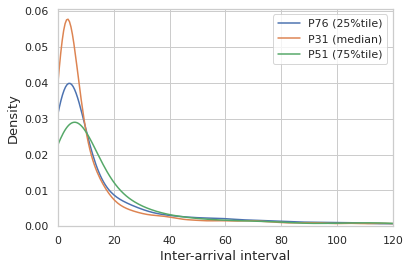

In [ ]:
plt.xlim(0,120)
sns.kdeplot(list(df_25.arrival_interval), kernel="gau" ,gridsize=4500, label="P76 (25%tile)")
sns.kdeplot(list(df_50.arrival_interval), kernel="gau" ,gridsize=4500, label="P31 (median)")
sns.kdeplot(list(df_75.arrival_interval), kernel="gau" ,gridsize=4500, label="P51 (75%tile)")
plt.xlabel('Inter-arrival interval', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.show()

We conducted a goodness of fit test to investigate the distribution of student arrival intervals. However, no statistical validity was found for 81 students.


In [ ]:
from sklearn.preprocessing import StandardScaler
import scipy
import math

In [ ]:
y=np.array(df_25.arrival_interval, dtype='float64')
x = np.arange(len(y))
size=len(y)
sc=StandardScaler() 
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [ ]:
dist_names = ['beta',
              'loggamma',
              'logistic',
              'expon',
              'truncexpon',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=sorted(percentile_cutoffs)))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nRemoval distributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Removal distributions sorted by goodness of fit:
----------------------------------------
   Distribution    chi_square  p_value
3         expon  4.298580e+04      0.0
11  weibull_max  5.410760e+04      0.0
2      logistic  6.099691e+04      0.0
6          norm  8.002143e+04      0.0
1      loggamma  8.219227e+04      0.0
8        triang  1.023700e+05      0.0
4    truncexpon  1.042202e+05      0.0
9       uniform  1.059988e+05      0.0
5       lognorm  3.814128e+05      0.0
0          beta  1.362530e+06      0.0
10  weibull_min  1.367084e+06      0.0
7      pearson3  1.410752e+06      0.0


###Bulk arrival process

we obsered stdents's inter-arrival intervals were concentrated within few seconds. and we assumed that these arrival patterns are unique characteristics of MIM; i.e., text typing in MIM requires some time although inter-arrivals can be short. MIM users tend to exchange messages in units of sentences rather than long sentences at once.

In [ ]:
path='gdrive/My Drive/project/bulk'
IDlist=os.listdir(path)
bulk=[]
bulk_mean=[]
bulk_median=[]


for ID in IDlist:

    df_bulk=pd.read_csv("gdrive/My Drive/project/bulk/"+ID)
    bulk2=[]

    for i in range(1,len(df_bulk)):
        if df_bulk[' title'][i]==df_bulk[' title'][i-1] and df_bulk[' title'][i]!=' null':
            bulk.append(df_bulk['arrival_interval'][i])
            bulk2.append(df_bulk['arrival_interval'][i])
    bulk_mean.append(np.mean(bulk2))
    bulk_median.append(np.median(bulk2))

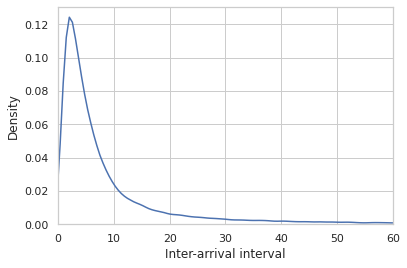

In [ ]:
plt.xlim(0,60)
sns.kdeplot(bulk, kernel="gau" ,gridsize=4500)
plt.xlabel('Inter-arrival interval')
plt.ylabel('Density')
plt.show()

In [ ]:
# percentage of evnets occured within 10 seconds
len([x for x in bulk if x<=10])/len(bulk)*100

71.93683193086196

71.93% of inter-arrival intervals were concentrated within 10 seconds. This bulk arrival pattern was partly due to the MIM's characteristic of exchanging short sentences. For this reason, we treated the set of arrivals from the same sender within a 10-second window as one bulk arrival

In [ ]:
# consider bulk arrival
#
df_25['bulk']=None
for i in range(1,len(df_25)):
    if df_25[' title'][i]==df_25[' title'][i-1] and df_25[' title'][i]!=' null':
        if df_25['arrival_interval'][i]<=10:
            df_25['bulk'][i]='y'
df_25b=df_25[df_25['bulk']!="y"]

df_50['bulk']=None
for i in range(1,len(df_50)):
    if df_50[' title'][i]==df_50[' title'][i-1] and df_50[' title'][i]!=' null':
        if df_50['arrival_interval'][i]<=10:
            df_50['bulk'][i]='y'
df_50b=df_50[df_50['bulk']!="y"]

df_75['bulk']=None
for i in range(1,len(df_75)):
    if df_75[' title'][i]==df_75[' title'][i-1] and df_75[' title'][i]!=' null':
        if df_75['arrival_interval'][i]<=10:
            df_75['bulk'][i]='y'
df_75b=df_75[df_75['bulk']!="y"]

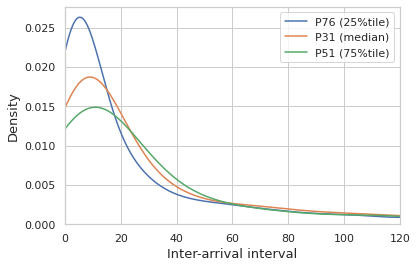

In [ ]:
plt.xlim(0,120)
sns.kdeplot(list(df_25b.arrival_interval), kernel="gau" ,gridsize=4500, label="P76 (25%tile)")
sns.kdeplot(list(df_50b.arrival_interval), kernel="gau" ,gridsize=4500, label="P31 (median)")
sns.kdeplot(list(df_75b.arrival_interval), kernel="gau" ,gridsize=4500, label="P51 (75%tile)")
plt.xlabel('Inter-arrival interval', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.show()

we observed that some of the extremely left-skewed data were now removed, and the density function had a heavy tail. The result of goodness of fit showed that 59 students (72.83\%) followed log-normal distributions

###Checking process

In a similar way, we captured inter-checking intervals and the number of checking events, and we selected three students, whose notification checking intervals was 25th percentile (M = 208.60s, SD = 455.69), median (M = 421.98s, SD = 690.82) and 75th percentile (M = 594.76, SD = 932.01) to consider overall students' checking process.

In [ ]:
ID_25R='50116575'
ID_50R='89242282'
ID_75R='65044529'
df_25R=pd.read_csv("gdrive/My Drive/project/checking/"+ID_25R+".csv")
df_50R=pd.read_csv("gdrive/My Drive/project/checking/"+ID_50R+".csv")
df_75R=pd.read_csv("gdrive/My Drive/project/checking/"+ID_75R+".csv")

In [ ]:
df_25R.head()

,classname,timestamp,type,package,title,text,subtext,start_time,Second,day,arrival_interval
0,선형대수학개론-A&B,2017.09.11_13.04.20,POSTED,com.kakao.talk,null,null,2개의 안 읽은 메시지,46800,47060,2017.09.11,260
1,선형대수학개론-A&B,2017.09.11_13.05.18,POSTED,com.kakao.talk,정은,새로운 메시지가 있습니다.,null,46800,47118,2017.09.11,58
2,선형대수학개론-A&B,2017.09.11_13.05.31,POSTED,com.kakao.talk,정은,새로운 메시지가 있습니다.,null,46800,47131,2017.09.11,13
3,선형대수학개론-A&B,2017.09.11_13.07.19,POSTED,com.kakao.talk,정은,새로운 메시지가 있습니다.,null,46800,47239,2017.09.11,108
4,선형대수학개론-A&B,2017.09.11_13.12.33,POSTED,com.kakao.talk,정은,새로운 메시지가 있습니다.,null,46800,47553,2017.09.11,314


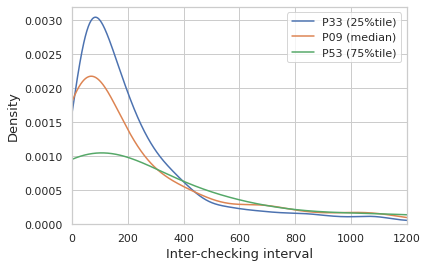

In [ ]:
plt.xlim(0,1200)
sns.kdeplot(list(df_25R.removal_interval), kernel="gau" ,gridsize=4500, label="P33 (25%tile)")
sns.kdeplot(list(df_50R.removal_interval), kernel="gau" ,gridsize=4500, label="P09 (median)")
sns.kdeplot(list(df_75R.removal_interval), kernel="gau" ,gridsize=4500, label="P53 (75%tile)")
plt.xlabel('Inter-checking interval', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.show()

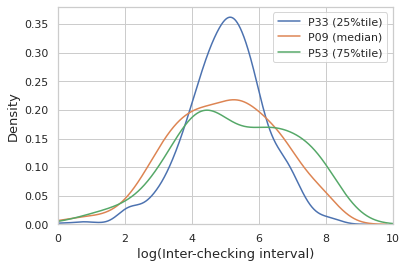

In [ ]:
x1=df_25R.removal_interval.astype('float')
x2=df_50R.removal_interval.astype('float')
x3=df_75R.removal_interval.astype('float')
# ploting after log-transformation
plt.xlim(0,10)
sns.kdeplot(list(np.log(x1+1)), kernel="gau" ,gridsize=4500, label="P33 (25%tile)")
sns.kdeplot(list(np.log(x2+1)), kernel="gau" ,gridsize=4500, label="P09 (median)")
sns.kdeplot(list(np.log(x3+1)), kernel="gau" ,gridsize=4500, label="P53 (75%tile)")
plt.xlabel('log(Inter-checking interval)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.show()

We found that 26 students (32.10\%) followed log-normal distributions.

## Correlation analysis

In [ ]:
# For analysis, we make data frame  that combines the features extracted above and students' information.
df_overall=pd.read_csv("gdrive/My Drive/project/csv_file/overall.csv")
df_overall.head()

,ID,overall_usgae,average_usgae,overall_app,average_app,overall_interaction,average_interaction,E_ig_per_class,E_nl_per_class,E_nu_per_class,E_uu_per_class,I_uu_per_class,E_nu_duration,E_uu_duration,I_uu_duration,E_nu_app,E_uu_app,I_uu_app,E_nu_interaction,E_uu_interaction,I_uu_interaction,E_ig_ratio,E_nl_ratio,E_nu_ratio,E_uu_ratio,inter_arrival_interval,inter_checking_interval,number_of_arrivals,number_of_checkings,Addiction,Gender,GPA
0,20946596,1589.973420,255.836708,19.938272,3.197640,913.802469,156.117246,2.35,2.83,1.96,1.86,4.99,351.45,199.10,242.55,4.34,3.64,2.79,171.91,133.24,153.40,0.39,0.44,0.42,0.26,51.07,352.52,67.77,24.06,37.50,M,2.38
1,22536401,420.200857,96.536672,3.471429,0.791415,150.285714,36.460449,6.35,2.77,2.13,1.06,2.84,111.90,203.92,77.82,1.63,1.44,0.31,56.34,87.47,21.42,0.59,0.34,0.26,0.12,48.29,941.59,82.33,38.20,22.25,M,3.94
2,22682373,1305.484325,103.591059,21.950000,1.480982,1048.425000,76.108671,15.54,1.86,4.23,2.47,10.20,75.56,68.66,98.78,1.69,1.58,1.23,68.94,62.83,75.73,0.64,0.09,0.22,0.15,88.75,331.06,43.36,27.71,37.50,M,3.67
3,22785668,829.403284,105.144692,14.790123,1.588203,529.444444,66.651395,2.78,3.78,3.17,2.48,5.34,161.66,84.90,80.56,2.43,1.85,1.09,74.76,79.49,51.51,0.34,0.39,0.36,0.26,83.03,271.58,46.62,25.67,37.25,M,3.03
4,22955826,1006.872029,122.450609,7.571429,0.761375,450.914286,56.511730,6.91,2.00,1.58,1.00,13.06,165.49,233.67,86.87,1.72,1.33,0.56,98.83,157.00,30.82,0.83,0.30,0.45,0.22,63.35,245.77,67.31,36.50,20.75,F,3.10


### Relationship between inter-arrival interval and inter-checking interval 


In [ ]:
df_overall.iloc[:,25:29].corr()

,inter_arrival_interval,inter_checking_interval,number_of_arrivals,number_of_checkings
inter_arrival_interval,1.000000,0.481802,-0.575460,-0.363092
inter_checking_interval,0.481802,1.000000,-0.339594,-0.433041
number_of_arrivals,-0.575460,-0.339594,1.000000,0.427983
number_of_checkings,-0.363092,-0.433041,0.427983,1.000000


In summary, the relationship between inter-arrival interval and inter-checking interval is as follows.
![correlation](https://drive.google.com/uc?id=101WBgwzKNvA0fZDuxYVaxxpTwO1C1yQ_)




###Relationship between notification handling behavior and checking process & smartphone usage

In [ ]:
df_overall.iloc[:,[1,2,3,4,5,6,21,22,23,24,26,28]].corr()

,overall_usgae,average_usgae,overall_app,average_app,overall_interaction,average_interaction,E_ig_ratio,E_nl_ratio,E_nu_ratio,E_uu_ratio,inter_checking_interval,number_of_checkings
overall_usgae,1.000000,0.449981,0.737162,0.436733,0.736279,0.429769,-0.381158,-0.102967,-0.095738,-0.118179,-0.580338,0.471621
average_usgae,0.449981,1.000000,0.111154,0.547519,0.223568,0.588657,-0.114975,0.336250,0.195630,0.095446,-0.141926,0.118557
overall_app,0.737162,0.111154,1.000000,0.686060,0.592040,0.225459,-0.584510,-0.250296,0.001872,-0.200798,-0.555934,0.637450
average_app,0.436733,0.547519,0.686060,1.000000,0.304095,0.417302,-0.473972,-0.007914,0.220953,-0.084285,-0.292518,0.388805
overall_interaction,0.736279,0.223568,0.592040,0.304095,1.000000,0.749557,-0.243733,-0.322445,-0.162845,-0.205568,-0.531641,0.258258
average_interaction,0.429769,0.588657,0.225459,0.417302,0.749557,1.000000,-0.039713,-0.095625,-0.056576,-0.092777,-0.332699,0.082133
E_ig_ratio,-0.381158,-0.114975,-0.584510,-0.473972,-0.243733,-0.039713,1.000000,-0.031836,-0.263562,0.257974,0.255442,-0.263642
E_nl_ratio,-0.102967,0.336250,-0.250296,-0.007914,-0.322445,-0.095625,-0.031836,1.000000,0.466434,0.627624,0.411769,-0.048220
E_nu_ratio,-0.095738,0.195630,0.001872,0.220953,-0.162845,-0.056576,-0.263562,0.466434,1.000000,0.494122,0.182389,-0.187621
E_uu_ratio,-0.118179,0.095446,-0.200798,-0.084285,-0.205568,-0.092777,0.257974,0.627624,0.494122,1.000000,0.232521,-0.069158


In summary, the relationship between notification handling behavior and checking process & smartphone usage is as follows.

![대체 텍스트](https://drive.google.com/uc?id=1V93kEwJ8yDrHF8n-X9qviIfA2P-opoSP)

##ANOVA

We compared session-level usage metrics in three unlocked usage sessions ($E_{nu}$, $E_{uu}$, and $I_{uu}$) to find out the impact of notifications on the use of smartphones. Here, the session-level usage metrics include usage duration, the number of apps used, and the number of interactions within a session. To compare these metrics in each session, we first tested whether the metrics were statistically different among three sessions through a one-way ANOVA. If there was a statistically significant difference, we then performed pairwise comparison using Tukey HSD for Post-hoc tests to review the difference in metrics between sessions. 

### Duration

In [ ]:
#construct dataset
duration=pd.concat([df_overall['E_nu_duration'], df_overall['E_uu_duration'], df_overall['I_uu_duration']], axis=0)
duration=pd.DataFrame(duration, columns=['duration']).reset_index(drop=True)
duration['type']=None
duration['ID']=None
duration['type'][0:81]='E_nu'
duration['type'][81:162]='E_uu'
duration['type'][162:]='I_uu'
duration['ID'][0:81]=df_overall.index
duration['ID'][81:162]=df_overall.index
duration['ID'][162:]=df_overall.index
duration.head()

,duration,type,ID
0,351.45,E_nu,0
1,111.90,E_nu,1
2,75.56,E_nu,2
3,161.66,E_nu,3
4,165.49,E_nu,4


In [ ]:
#Repeated measure ANOVA
import pingouin as pg
aov=pg.rm_anova(dv='duration',  within='type', subject="ID",  data=duration,  detailed=True)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF         MS  F       p-unc                  p-GG-corr               np2    eps    sphericity    W-spher    p-spher
--------  ----------  ----  ---------  ------  ---------------------  ----------------------  -----  -----  ------------  ---------  ----------------------
type      128516.969     2  64258.484  16.264  3.714808967802566e-07  2.5637884197051887e-06  0.169  0.833  False         0.8        0.00014753154473242454
Error     632138.124   160   3950.863  -       -                      -                       -      -      -             -          -



In [ ]:
# Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(duration['duration'], duration['type'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  E_nu   E_uu -44.0031 0.0015 -73.5647 -14.4415   True
  E_nu   I_uu -52.4604  0.001  -82.022 -22.8988   True
  E_uu   I_uu  -8.4573 0.7583 -38.0189  21.1043  False
------------------------------------------------------


### Number of apps used


In [ ]:
#construct dataset
app=pd.concat([df_overall['E_nu_app'], df_overall['E_uu_app'], df_overall['I_uu_app']], axis=0)
app=pd.DataFrame(app, columns=['apps_used']).reset_index(drop=True)
app['type']=None
app['ID']=None
app['type'][0:81]='E_nu'
app['type'][81:162]='E_uu'
app['type'][162:]='I_uu'
app['ID'][0:81]=df_overall.index
app['ID'][81:162]=df_overall.index
app['ID'][162:]=df_overall.index
app.head()

,apps_used,type,ID
0,4.34,E_nu,0
1,1.63,E_nu,1
2,1.69,E_nu,2
3,2.43,E_nu,3
4,1.72,E_nu,4


In [ ]:
#Repeated measure ANOVA
import pingouin as pg
aov=pg.rm_anova(dv='apps_used',  within='type', subject="ID",  data=app,  detailed=True)
pg.print_table(aov)


ANOVA SUMMARY

Source         SS    DF      MS  F       p-unc                  p-GG-corr               np2    eps    sphericity    W-spher    p-spher
--------  -------  ----  ------  ------  ---------------------  ----------------------  -----  -----  ------------  ---------  ---------------------
type       53.939     2  26.970  37.887  3.388999151300161e-14  1.3261323824189598e-12  0.321  0.865  False         0.844      0.0012353477573783717
Error     113.897   160   0.712  -       -                      -                       -      -      -             -          -



In [ ]:
# Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(app['apps_used'], app['type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  E_nu   E_uu  -0.2657 0.2439  -0.655  0.1237  False
  E_nu   I_uu  -1.1054  0.001 -1.4948 -0.7161   True
  E_uu   I_uu  -0.8398  0.001 -1.2291 -0.4504   True
----------------------------------------------------


### Number of interaction

In [ ]:
#construct dataset
interaction=pd.concat([df_overall['E_nu_app'], df_overall['E_uu_app'], df_overall['I_uu_app']], axis=0)
interaction=pd.DataFrame(interaction, columns=['interaction']).reset_index(drop=True)
interaction['type']=None
interaction['ID']=None
interaction['type'][0:81]='E_nu'
interaction['type'][81:162]='E_uu'
interaction['type'][162:]='I_uu'
interaction['ID'][0:81]=df_overall.index
interaction['ID'][81:162]=df_overall.index
interaction['ID'][162:]=df_overall.index
interaction.head()

,interaction,type,ID
0,4.34,E_nu,0
1,1.63,E_nu,1
2,1.69,E_nu,2
3,2.43,E_nu,3
4,1.72,E_nu,4


In [ ]:
#Repeated measure ANOVA
import pingouin as pg
aov=pg.rm_anova(dv='interaction',  within='type', subject="ID",  data=interaction,  detailed=True)
pg.print_table(aov)


ANOVA SUMMARY

Source         SS    DF      MS  F       p-unc                  p-GG-corr               np2    eps    sphericity    W-spher    p-spher
--------  -------  ----  ------  ------  ---------------------  ----------------------  -----  -----  ------------  ---------  ---------------------
type       53.939     2  26.970  37.887  3.388999151300161e-14  1.3261323824189598e-12  0.321  0.865  False         0.844      0.0012353477573783717
Error     113.897   160   0.712  -       -                      -                       -      -      -             -          -



In [ ]:
# Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(interaction['interaction'], interaction['type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  E_nu   E_uu  -0.2657 0.2439  -0.655  0.1237  False
  E_nu   I_uu  -1.1054  0.001 -1.4948 -0.7161   True
  E_uu   I_uu  -0.8398  0.001 -1.2291 -0.4504   True
----------------------------------------------------


##Hypothesis test

In [ ]:
import os
import pandas as pd
path='/content/gdrive/My Drive/project (1)/class_app_usage'
IDlist=os.listdir(path)

In [ ]:
def remove_space(x):
    if " " in x:
        x=x[1:]
    return x

In [ ]:
def day(x):
    return x.split('_')[0]

### Select subject

#### Extract students' modalities

In [ ]:
df_arrival

,timestamp,type,package,title,text,subtext,sound,vibrate,defaults,ledon,ledoff,ledrgb,modality
0,POSTED,POSTED,com.kakao.talk,임근우 새터16반 남프,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
1,POSTED,POSTED,com.kakao.talk,임근우 새터16반 남프,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
2,POSTED,POSTED,com.kakao.talk,임근우 새터16반 남프,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
4,POSTED,POSTED,com.kakao.talk,최성준 K17 98,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
6,POSTED,POSTED,com.kakao.talk,박준호 K17 99,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150206,POSTED,POSTED,com.kakao.talk,null,null,5개의 안 읽은 메시지,,null,0,0,0,0,NaN
150208,POSTED,POSTED,com.kakao.talk,혜연Rachel 모카,새로운 메시지가 있습니다.,null,,null,0,0,0,0,NaN
150211,POSTED,POSTED,com.kakao.talk,이은성 K17 98,새로운 메시지가 있습니다.,null,,[0,0],0,300,5000,NaN
150212,POSTED,POSTED,com.kakao.talk,이은성 K17 98,새로운 메시지가 있습니다.,null,,[0,0],0,300,5000,NaN


In [ ]:
vib=[]
sil=[]
nor=[]
arrival=[]
checking=[]
for ID in IDlist:
    
    df_mode=pd.read_csv("/content/gdrive/My Drive/project (1)/raw_data/"+ID+"/RINGER_"+ID+".csv" , error_bad_lines=False)
    df_noti=pd.read_csv("/content/gdrive/My Drive/project (1)/raw_data/"+ID+"/NOTIFICATION_"+ID+".csv" , error_bad_lines=False)
    df_noti['timestamp']=df_noti.iloc[:,1:2].applymap(remove_space)
    
    for i in range(len(df_mode)-1):
        start_time=df_mode['timestamp'][i]
        end_time=df_mode['timestamp'][i+1]
        df_noti.loc[(start_time <= df_noti.timestamp) & (df_noti.timestamp< end_time), 'modality']=df_mode[' mode'][i]
    df_kakao=df_noti[df_noti[' package']==' com.kakao.talk'].reset_index(drop=True)
    if len(df_kakao)==0:
        continue
    df_arrival=df_kakao[df_kakao[' type']==" POSTED"]
    df_checking=df_kakao[df_kakao[' type']==" REMOVED"]
    arrival.append(len(df_arrival))
    checking.append(len(df_checking))
    df_kakao_vib=df_arrival[df_arrival['modality']==' vibrate']
    df_kakao_sil=df_arrival[df_arrival['modality']==' silent']
    df_kakao_nor=df_arrival[df_arrival['modality']==' normal']
    vib.append(len(df_kakao_vib))
    sil.append(len(df_kakao_sil))
    nor.append(len(df_kakao_nor))


b'Skipping line 128495: expected 12 fields, saw 13\n'
b'Skipping line 78315: expected 12 fields, saw 13\n'
b'Skipping line 334322: expected 12 fields, saw 18\n'
b'Skipping line 130243: expected 12 fields, saw 15\nSkipping line 130268: expected 12 fields, saw 14\nSkipping line 130273: expected 12 fields, saw 14\nSkipping line 130278: expected 12 fields, saw 14\nSkipping line 130283: expected 12 fields, saw 13\nSkipping line 130952: expected 12 fields, saw 15\n'
b'Skipping line 131194: expected 12 fields, saw 14\nSkipping line 131196: expected 12 fields, saw 14\nSkipping line 131198: expected 12 fields, saw 14\nSkipping line 131560: expected 12 fields, saw 14\nSkipping line 131583: expected 12 fields, saw 15\nSkipping line 132313: expected 12 fields, saw 15\n'
b'Skipping line 331112: expected 12 fields, saw 13\n'
b'Skipping line 456145: expected 12 fields, saw 18\n'
b'Skipping line 98935: expected 12 fields, saw 14\nSkipping line 99361: expected 12 fields, saw 14\n'
b'Skipping line 15318

In [ ]:
modality_df=pd.DataFrame({"ID":IDlist, "v":vib,"s":sil,"n":nor})
modality_df.head()

,ID,n,s,v
0,20946596,0,153,6760
1,22536401,0,5709,1124
2,22682373,0,1617,204
3,22785668,0,266,3930
4,22955826,15,690,170


#### Selection criteria

1. The number of notification events are more than 10
2. We compared notification inter-checking intervals from those who use both vibration and silent modes.
3. Therefore, we excluded participants who focused only on one modality.


In [ ]:
v=0
s=0
v_s=0
ot=0
selected_ID=[]
for i in range(len(modality_df)):
    if modality_df['s'][i]<=10 and modality_df['v'][i]<=10:
        continue
    elif modality_df['n'][i]>800:
        ot+=1
    elif modality_df['s'][i]> modality_df['v'][i]*50:
        s+=1
    elif modality_df['s'][i]*50 < modality_df['v'][i]:
        v+=1
    else:
        v_s+=1
        selected_ID.append(modality_df['ID'][i])

In [ ]:
print("The number of selected students is {}".format(v_s))

The number of selected students is 49


#### Comparison

In [ ]:
vib_mean=[]
vib_median=[]
sil_mean=[]
sil_median=[]
vib_per_class=[]
sil_per_class=[]
p_value=[]
ID_list=[]
for ID in IDlist:
    print(ID)
    df_mode=pd.read_csv("/content/gdrive/My Drive/project (1)/raw_data/"+ID+"/RINGER_"+ID+".csv" , error_bad_lines=False)
    df_noti=pd.read_csv("/content/gdrive/My Drive/project (1)/raw_data/"+ID+"/NOTIFICATION_"+ID+".csv" , error_bad_lines=False)
    df_noti['timestamp']=df_noti.iloc[:,1:2].applymap(remove_space)
    df_noti['day']=df_noti.iloc[:,1:2].applymap(day)

    for i in range(len(df_mode)-1):
        start_time=df_mode['timestamp'][i]
        end_time=df_mode['timestamp'][i+1]
        df_noti.loc[(start_time <= df_noti.timestamp) & (df_noti.timestamp< end_time), 'modality']=df_mode[' mode'][i]

    df_kakao=df_noti[df_noti[' package']==' com.kakao.talk'].reset_index(drop=True)
    if len(df_kakao)==0:
        print("Removed ID"+ ID)
        continue
    prev_class=df_kakao['classname'][0]
    start=0
    for i in range(len(df_kakao)):
        curr_class=df_kakao['classname'][i]
        if prev_class!=curr_class:
            end=i
            mode=df_kakao.iloc[start:end].groupby("modality").count().reset_index().sort_values(['modality'], ascending=False)['modality'][0]
            df_kakao[start:end]['modality']=mode
            start=end
        prev_class=curr_class
    
    df_kakao["start_time"]=None
    for i in range(len(df_kakao)):
        df_kakao["start_time"][i]=class_list[df_kakao['classname'][i]]
        
    df_kakao["start_time"]=df_kakao.iloc[:,9:10].applymap(start_time1)
    df_kakao["Second"]=df_kakao.iloc[:,1:2].applymap(time_transform)
    
    df_kakao_vib=df_kakao[df_kakao['modality']==' vibrate'].reset_index(drop=True)
    df_kakao_sil=df_kakao[df_kakao['modality']==' silent'].reset_index(drop=True)
    
    if len(df_kakao_vib)==0 or len(df_kakao_sil)==0:
        print("Removed ID"+ ID)
 
        continue
    
    df_kakao_vib['removal_interval']=None
    prev_class=None
    prev_time=None
    prev_type=None
    for i in range(len(df_kakao_vib)):
        if df_kakao_vib[' type'][i]==' POSTED':
            prev_type=' POSTED'
            continue

        curr_class=df_kakao_vib['classname'][i]
        curr_time=df_kakao_vib['Second'][i]
        curr_type=df_kakao_vib[' type'][i]
        if prev_class!=curr_class:
            df_kakao_vib['removal_interval'][i]=curr_time-df_kakao_vib['start_time'][i]
            prev_class=curr_class
            prev_time=curr_time
            prev_type=curr_type
        else:
            if prev_type!=curr_type:
                df_kakao_vib['removal_interval'][i]=curr_time-prev_time
                prev_class=curr_class
                prev_time=curr_time
                prev_type=curr_type
    df_kakao_vib_removed=df_kakao_vib[df_kakao_vib[' type']==' REMOVED'].dropna(axis=0).reset_index(drop=True)
    
    df_kakao_sil['removal_interval']=None
    prev_class=None
    prev_time=None
    prev_type=None
    for i in range(len(df_kakao_sil)):
        if df_kakao_sil[' type'][i]==' POSTED':
            prev_type=' POSTED'
            continue

        curr_class=df_kakao_sil['classname'][i]
        curr_time=df_kakao_sil['Second'][i]
        curr_type=df_kakao_sil[' type'][i]
        if prev_class!=curr_class:
            df_kakao_sil['removal_interval'][i]=curr_time-df_kakao_sil['start_time'][i]
            prev_class=curr_class
            prev_time=curr_time
            prev_type=curr_type
        else:
            if prev_type!=curr_type:
                df_kakao_sil['removal_interval'][i]=curr_time-prev_time
                prev_class=curr_class
                prev_time=curr_time
                prev_type=curr_type
    df_kakao_sil_removed=df_kakao_sil[df_kakao_sil[' type']==' REMOVED'].dropna(axis=0).reset_index(drop=True)
    
    if len(df_kakao_vib_removed.groupby(['classname', 'day']).count())==0 or len(df_kakao_sil_removed.groupby(['classname', 'day']).count())==0:
        print("Removed ID2"+ ID)
        
        continue
    ID_list.append(ID)
    vib_mean.append(df_kakao_vib_removed['removal_interval'].mean())
    sil_mean.append(df_kakao_sil_removed['removal_interval'].mean())
    vib_median.append(df_kakao_vib_removed['removal_interval'].median())
    sil_median.append(df_kakao_sil_removed['removal_interval'].median())
    vib_per_class.append(len(df_kakao_vib_removed)/len(df_kakao_vib_removed.groupby(['classname', 'day']).count()))
    sil_per_class.append(len(df_kakao_sil_removed)/len(df_kakao_sil_removed.groupby(['classname', 'day']).count()))
    p_value.append(stats.ttest_ind(df_kakao_vib_removed.removal_interval,df_kakao_sil_removed.removal_interval, equal_var=False)[1])

###Result

In [ ]:
result={"ID": ID_list, "vib mean": vib_mean, "sil_mean": sil_mean ,"p value": p_value}
result=pd.DataFrame(result)

In [ ]:
result

,ID,p value,sil_mean,vib mean
0,20946596,0.958675,336.272727,345.357962
1,22536401,0.870821,911.657143,858.437500
2,22682373,0.957559,330.760349,342.666667
3,22785668,0.003244,144.162791,290.727453
4,22955826,0.743624,261.016949,321.468750
5,24897713,0.439871,241.156863,217.195212
6,25063234,0.663924,299.411531,448.380952
7,25464368,0.414631,559.812500,439.347032
8,27502754,0.003407,580.178218,1986.000000
9,27965866,0.300766,96.034871,70.000000


In [ ]:
len(result[result['p value']>=0.05])

37

In [ ]:
len(result[result['p value']<=0.05])

12

In [ ]:
result[result['p value']<=0.05]

,ID,p value,sil_mean,vib mean
3,22785668,0.003244,144.162791,290.727453
8,27502754,0.003407,580.178218,1986.000000
13,40325607,0.022369,326.056848,228.220000
16,41884980,0.027280,352.851351,541.221719
18,47043065,0.007832,230.966102,535.269912
26,52565188,0.041618,158.284553,263.857605
30,57670750,0.042359,216.790865,773.727273
32,63987688,0.000147,482.699208,173.707143
34,66080208,0.032062,835.834586,3064.333333
42,89215319,0.009103,536.448193,1053.339623


#Modeling

The arrival factor is also dependent on modality (sound, silence, or vibration), and thus, its relationship with the checking factor (inter-checking interval) was statistically tested through hypothesis testing.

##Multiple Regression

 we performed a hierarchical multiple regression on the student's end-of-semester GPAs. The first block included a students' gender and addiction score as a baseline, the second block additionally includes session-level smartphone usage metrics. The remaining metrics were included in the third block, i.e., in-class notification arrival/checking metrics and its reaction preference

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Setting for regression: Convert gender to dummy variable
df_overall= pd.get_dummies(df_overall, columns=['Gender'])
df_overall=df_overall.rename(columns={"Gender_ F":"Gender_F", "Gender_ M":"Gender_M" })
df_overall.head()

,ID,overall_usgae,average_usgae,overall_app,average_app,overall_interaction,average_interaction,E_ig_per_class,E_nl_per_class,E_nu_per_class,E_uu_per_class,I_uu_per_class,E_nu_duration,E_uu_duration,I_uu_duration,E_nu_app,E_uu_app,I_uu_app,E_nu_interaction,E_uu_interaction,I_uu_interaction,E_ig_preference,E_nl_preference,E_nu_preference,E_uu_preference,inter_arrival_interval,inter_checking_interval,number_of_arrivals,number_of_checkings,Addiction,GPA,Gender_F,Gender_M
0,20946596,1589.973420,255.836708,19.938272,3.197640,913.802469,156.117246,2.35,2.83,1.96,1.86,4.99,351.45,199.10,242.55,4.34,3.64,2.79,171.91,133.24,153.40,0.39,0.44,0.42,0.26,51.07,352.52,67.77,24.06,37.50,2.38,0,1
1,22536401,420.200857,96.536672,3.471429,0.791415,150.285714,36.460449,6.35,2.77,2.13,1.06,2.84,111.90,203.92,77.82,1.63,1.44,0.31,56.34,87.47,21.42,0.59,0.34,0.26,0.12,48.29,941.59,82.33,38.20,22.25,3.94,0,1
2,22682373,1305.484325,103.591059,21.950000,1.480982,1048.425000,76.108671,15.54,1.86,4.23,2.47,10.20,75.56,68.66,98.78,1.69,1.58,1.23,68.94,62.83,75.73,0.64,0.09,0.22,0.15,88.75,331.06,43.36,27.71,37.50,3.67,0,1
3,22785668,829.403284,105.144692,14.790123,1.588203,529.444444,66.651395,2.78,3.78,3.17,2.48,5.34,161.66,84.90,80.56,2.43,1.85,1.09,74.76,79.49,51.51,0.34,0.39,0.36,0.26,83.03,271.58,46.62,25.67,37.25,3.03,0,1
4,22955826,1006.872029,122.450609,7.571429,0.761375,450.914286,56.511730,6.91,2.00,1.58,1.00,13.06,165.49,233.67,86.87,1.72,1.33,0.56,98.83,157.00,30.82,0.83,0.30,0.45,0.22,63.35,245.77,67.31,36.50,20.75,3.10,1,0


## Block 1

Blcok1 contained **gender** and addiction score as baseline

In [ ]:
df_block1=df_overall[['Gender_M', 'Addiction', "GPA"]]
df_block1.head()

,Gender_M,Addiction,GPA
0,1,37.50,2.38
1,1,22.25,3.94
2,1,37.50,3.67
3,1,37.25,3.03
4,0,20.75,3.10


In [ ]:
features=""
for feature in df_block1.columns:
    if feature!="GPA":
        features+=feature+"+"
features=features[:-1]
print(features)

y,X = dmatrices("GPA~" + features, data=df_block1, return_type="dataframe")
vif=pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']=X.columns
result=sm.OLS(y,X).fit()
vif.sort_values(['VIF'], ascending=False).head(3)

Gender_M+Addiction


,VIF,features
0,19.451897,Intercept
2,1.012553,Addiction
1,1.012553,Gender_M


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.723
Date:                Tue, 05 May 2020   Prob (F-statistic):              0.185
Time:                        01:28:46   Log-Likelihood:                -61.020
No. Observations:                  81   AIC:                             128.0
Df Residuals:                      78   BIC:                             135.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3672      0.257     13.119      0.000       2.856       3.878
Gender_M       0.2017      0.125      1.608      0.112      -0.048       0.451
Addiction     -0.0056      0.008     -0.744      0.459      -0.021       0.009
==============================================================================
Omnibus:                        5.592   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.029
Skew:                          -0.599   Prob(JB):                       0.0809
Kurtosis:                       3.237   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Block 2

Block2 additionally contained smartphone usage metrics (# of sessions, session duration)

In [ ]:
df_block2=df_overall[['E_ig_per_class','E_nl_per_class','E_nu_per_class','E_uu_per_class','I_uu_per_class','E_nu_duration','E_uu_duration','I_uu_duration','Addiction','Gender_M','GPA']]
df_block2.head()

,E_ig_per_class,E_nl_per_class,E_nu_per_class,E_uu_per_class,I_uu_per_class,E_nu_duration,E_uu_duration,I_uu_duration,Addiction,Gender_M,GPA
0,2.35,2.83,1.96,1.86,4.99,351.45,199.10,242.55,37.50,1,2.38
1,6.35,2.77,2.13,1.06,2.84,111.90,203.92,77.82,22.25,1,3.94
2,15.54,1.86,4.23,2.47,10.20,75.56,68.66,98.78,37.50,1,3.67
3,2.78,3.78,3.17,2.48,5.34,161.66,84.90,80.56,37.25,1,3.03
4,6.91,2.00,1.58,1.00,13.06,165.49,233.67,86.87,20.75,0,3.10


In [ ]:
features=""
for feature in df_block2.columns:
    if feature!="GPA":
        features+=feature+"+"
features=features[:-1]
print(features)

y,X = dmatrices("GPA~" + features, data=df_block2, return_type="dataframe")
vif=pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']=X.columns
result=sm.OLS(y,X).fit()
vif.sort_values(['VIF'], ascending=False).head(3)

E_ig_per_class+E_nl_per_class+E_nu_per_class+E_uu_per_class+I_uu_per_class+E_nu_duration+E_uu_duration+I_uu_duration+Addiction+Gender_M


,VIF,features
0,36.931121,Intercept
6,2.590871,E_nu_duration
2,1.778464,E_nl_per_class


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.309
Date:                Tue, 05 May 2020   Prob (F-statistic):              0.243
Time:                        01:35:25   Log-Likelihood:                -55.829
No. Observations:                  81   AIC:                             133.7
Df Residuals:                      70   BIC:                             160.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2089      0.350      9.165      0.000       2.511       3.907
E_ig_per_class     0.0142      0.020      0.694      0.490      -0.027       0.055
E_nl_per_class    -0.0411      0.072     -0.570      0.571      -0.185       0.103
E_nu_per_class     0.0468      0.039      1.198      0.235      -0.031       0.125
E_uu_per_class     0.0785      0.146      0.537      0.593      -0.213       0.370
I_uu_per_class     0.0177      0.019      0.935      0.353      -0.020       0.055
E_nu_duration     -0.0009      0.001     -0.791      0.432      -0.003       0.001
E_uu_duration      0.0002      0.001      0.233      0.816      -0.001       0.002
I_uu_duration     -0.0005      0.001     -0.421      0.675      -0.003       0.002
Addiction         -0.0051      0.008     -0.622      0.536      -0.021       0.011
Gender_M           0.2010      0.133      1.510      0.136      -0.065       0.467
==============================================================================
Omnibus:                        2.820   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.350
Skew:                          -0.414   Prob(JB):                        0.309
Kurtosis:                       3.099   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In this case, we observed a warning message that multicollinearity is high. Therefore, we removed variables in order of high p-value sequentially to remove multicollinearity. Through this process, E_uu_per_class, E_uu_duration, I_uu_duration, E_nl_per_class, Addiction socre, E_ig_per_class, and I_uu_per_class were removed stepwisely (the process is omitted)


### Backward elimination

In [ ]:
df_block2.drop(['E_uu_duration', 'E_uu_per_class', 'I_uu_duration', 'E_nl_per_class', 'Addiction'], axis=1, inplace=True)
features=""
for feature in df_block2.columns:
    if feature!="GPA":
        features+=feature+"+"
features=features[:-1]
print(features)

y,X = dmatrices("GPA~" + features, data=df_block2, return_type="dataframe")
vif=pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']=X.columns
result=sm.OLS(y,X).fit()

result.summary()

E_ig_per_class+E_nu_per_class+I_uu_per_class+E_nu_duration+Gender_M


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.501
Date:                Tue, 05 May 2020   Prob (F-statistic):             0.0378
Time:                        01:49:09   Log-Likelihood:                -56.527
No. Observations:                  81   AIC:                             125.1
Df Residuals:                      75   BIC:                             139.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.1547      0.251     12.591      0.000       2.656       3.654
E_ig_per_class     0.0140      0.018      0.772      0.442      -0.022       0.050
E_nu_per_class     0.0345      0.032      1.084      0.282      -0.029       0.098
I_uu_per_class     0.0172      0.017      0.982      0.329      -0.018       0.052
E_nu_duration     -0.0013      0.001     -1.828      0.071      -0.003       0.000
Gender_M           0.1980      0.122      1.628      0.108      -0.044       0.440
==============================================================================
Omnibus:                        3.481   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.923
Skew:                          -0.458   Prob(JB):                        0.232
Kurtosis:                       3.161   Cond. No.                         884.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##Block 3

In [ ]:
df_overall.columns

Index(['ID', 'overall_usgae', 'average_usgae', 'overall_app', 'average_app',
       'overall_interaction', 'average_interaction', 'E_ig_per_class',
       'E_nl_per_class', 'E_nu_per_class', 'E_uu_per_class', 'I_uu_per_class',
       'E_nu_duration', 'E_uu_duration', 'I_uu_duration', 'E_nu_app',
       'E_uu_app', 'I_uu_app', 'E_nu_interaction', 'E_uu_interaction',
       'I_uu_interaction', 'E_ig_preference', 'E_nl_preference',
       'E_nu_preference', 'E_uu_preference', 'inter_arrival_interval',
       'inter_checking_interval', 'number_of_arrivals', 'number_of_checkings',
       'Addiction', 'GPA', 'Gender_F', 'Gender_M'],
      dtype='object')

In [ ]:
df_block3=df_overall[['E_ig_per_class','E_nl_per_class','E_nu_per_class','E_uu_per_class','I_uu_per_class','E_nu_duration','E_uu_duration','I_uu_duration',
                      'E_ig_preference', 'E_nl_preference',       'E_nu_preference', 'E_uu_preference', 'inter_arrival_interval', 'inter_checking_interval',
                      'number_of_arrivals', 'number_of_checkings','Addiction','Gender_M','GPA']]
df_block3.head()

,E_ig_per_class,E_nl_per_class,E_nu_per_class,E_uu_per_class,I_uu_per_class,E_nu_duration,E_uu_duration,I_uu_duration,E_ig_preference,E_nl_preference,E_nu_preference,E_uu_preference,inter_arrival_interval,inter_checking_interval,number_of_arrivals,number_of_checkings,Addiction,Gender_M,GPA
0,2.35,2.83,1.96,1.86,4.99,351.45,199.10,242.55,0.39,0.44,0.42,0.26,51.07,352.52,67.77,24.06,37.50,1,2.38
1,6.35,2.77,2.13,1.06,2.84,111.90,203.92,77.82,0.59,0.34,0.26,0.12,48.29,941.59,82.33,38.20,22.25,1,3.94
2,15.54,1.86,4.23,2.47,10.20,75.56,68.66,98.78,0.64,0.09,0.22,0.15,88.75,331.06,43.36,27.71,37.50,1,3.67
3,2.78,3.78,3.17,2.48,5.34,161.66,84.90,80.56,0.34,0.39,0.36,0.26,83.03,271.58,46.62,25.67,37.25,1,3.03
4,6.91,2.00,1.58,1.00,13.06,165.49,233.67,86.87,0.83,0.30,0.45,0.22,63.35,245.77,67.31,36.50,20.75,0,3.10


In [ ]:
features=""
for feature in df_block3.columns:
    if feature!="GPA":
        features+=feature+"+"
features=features[:-1]
print(features)

y,X = dmatrices("GPA~" + features, data=df_block3, return_type="dataframe")
vif=pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']=X.columns
result=sm.OLS(y,X).fit()
vif.sort_values(['VIF'], ascending=False).head(3)

E_ig_per_class+E_nl_per_class+E_nu_per_class+E_uu_per_class+I_uu_per_class+E_nu_duration+E_uu_duration+I_uu_duration+E_ig_preference+E_nl_preference+E_nu_preference+E_uu_preference+inter_arrival_interval+inter_checking_interval+number_of_arrivals+number_of_checkings+Addiction+Gender_M


,VIF,features
0,361.659385,Intercept
11,6.600154,E_nu_preference
10,6.327253,E_nl_preference


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1.820
Date:                Tue, 05 May 2020   Prob (F-statistic):             0.0427
Time:                        01:52:50   Log-Likelihood:                -45.593
No. Observations:                  81   AIC:                             129.2
Df Residuals:                      62   BIC:                             174.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.8362      1.026      1.790      0.078      -0.215       3.887
E_ig_per_class             -0.0396      0.034     -1.164      0.249      -0.108       0.028
E_nl_per_class             -0.0883      0.110     -0.805      0.424      -0.307       0.131
E_nu_per_class              0.2127      0.068      3.121      0.003       0.076       0.349
E_uu_per_class              0.0129      0.208      0.062      0.951      -0.404       0.429
I_uu_per_class              0.0203      0.021      0.986      0.328      -0.021       0.061
E_nu_duration              -0.0018      0.001     -1.480      0.144      -0.004       0.001
E_uu_duration               0.0001      0.001      0.150      0.881      -0.002       0.002
I_uu_duration              -0.0001      0.001     -0.097      0.923      -0.003       0.002
E_ig_preference             2.0443      0.740      2.763      0.008       0.565       3.523
E_nl_preference             1.0670      1.033      1.033      0.306      -0.998       3.132
E_nu_preference            -0.9316      0.972     -0.958      0.342      -2.875       1.012
E_uu_preference             0.7606      1.059      0.718      0.475      -1.357       2.878
inter_arrival_interval     -0.0017      0.001     -1.514      0.135      -0.004       0.001
inter_checking_interval     0.0003      0.000      0.683      0.497      -0.000       0.001
number_of_arrivals          0.0006      0.001      0.487      0.628      -0.002       0.003
number_of_checkings         0.0047      0.005      0.964      0.339      -0.005       0.015
Addiction                   0.0017      0.009      0.194      0.847      -0.016       0.019
Gender_M                    0.1568      0.130      1.204      0.233      -0.103       0.417
==============================================================================
Omnibus:                        0.819   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.903
Skew:                          -0.140   Prob(JB):                        0.637
Kurtosis:                       2.566   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

similary, we observed a warning message that multicollinearity is high. Therefore, we removed variables in order of high p-value sequentially to remove multicollinearity. Through this process, E_uu_per_class, I_uu_duration, E_uu_duration, Addiction socre, number_of_arrivals, inter_checking_arrival, and I_uu_per_class were removed stepwisely (the process is omitted)

###Backward elimination

In [ ]:
df_block3.drop(['E_uu_per_class', 'I_uu_duration', 'E_uu_duration', 'Addiction', 'number_of_arrivals', 'inter_checking_interval', 'I_uu_per_class'], axis=1, inplace=True)
features=""
for feature in df_block3.columns:
    if feature!="GPA":
        features+=feature+"+"
features=features[:-1]
print(features)

y,X = dmatrices("GPA~" + features, data=df_block3, return_type="dataframe")
vif=pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']=X.columns
result=sm.OLS(y,X).fit()
result.summary()

E_ig_per_class+E_nl_per_class+E_nu_per_class+E_nu_duration+E_ig_preference+E_nl_preference+E_nu_preference+E_uu_preference+inter_arrival_interval+number_of_checkings+Gender_M


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     3.131
Date:                Tue, 05 May 2020   Prob (F-statistic):            0.00178
Time:                        02:01:01   Log-Likelihood:                -46.374
No. Observations:                  81   AIC:                             116.7
Df Residuals:                      69   BIC:                             145.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.3398      0.532      4.398      0.000       1.278       3.401
E_ig_per_class            -0.0425      0.031     -1.357      0.179      -0.105       0.020
E_nl_per_class            -0.0892      0.099     -0.904      0.369      -0.286       0.108
E_nu_per_class             0.2014      0.063      3.220      0.002       0.077       0.326
E_nu_duration             -0.0020      0.001     -2.542      0.013      -0.004      -0.000
E_ig_preference            2.0317      0.619      3.282      0.002       0.797       3.267
E_nl_preference            1.0411      0.803      1.297      0.199      -0.560       2.643
E_nu_preference           -1.0374      0.805     -1.289      0.202      -2.643       0.568
E_uu_preference            0.7351      0.752      0.978      0.332      -0.764       2.235
inter_arrival_interval    -0.0017      0.001     -1.851      0.068      -0.004       0.000
number_of_checkings        0.0053      0.004      1.414      0.162      -0.002       0.013
Gender_M                   0.1554      0.119      1.310      0.194      -0.081       0.392
==============================================================================
Omnibus:                        0.694   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.817
Skew:                          -0.148   Prob(JB):                        0.664
Kurtosis:                       2.607   Cond. No.                     4.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#Visualization

## Notification handling behaviors

We first looked at descriptive statistics to understand the in-class notification receipt/checking processes. We ploted the average of notification inter-arrival/checking intervals and the number of events for 81 students

### Number of arrivals/checking (frequency)

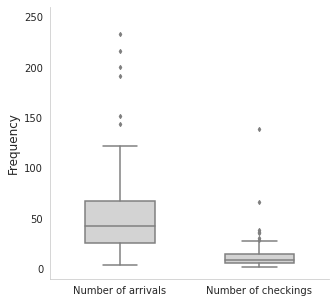

In [ ]:
a=pd.DataFrame({"frequency":df_overall['number_of_arrivals']})
a['type']="Number of arrivals"
b=pd.DataFrame({"frequency":df_overall['number_of_checkings']})
b['type']="Number of checkings"
c=pd.concat([a,b], axis=0)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(5, 5))
sns.despine(left=True, bottom=True, right=True)
ax=sns.boxplot(x="type", y="frequency",data=c, width=0.5, color="lightgray", fliersize=3)

#plt.setp(ax.lines, color=".1")
plt.xlabel('', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
ax.set_ylim([-10, 260])
for tick in ax.get_xticklines():
    tick.set_color('gray')
sns.despine(top=True, right= True,left=False, bottom=False)
plt.show()

###Inter-arrival/checking interval (interval)

In [ ]:
a=pd.DataFrame({"interval":df_overall['inter_arrival_interval']})
a['type']="Inter-arrival interval"
b=pd.DataFrame({"interval":df_overall['inter_checking_interval']})
b['type']="Inter-checking interval"
c=pd.concat([a,b], axis=0)

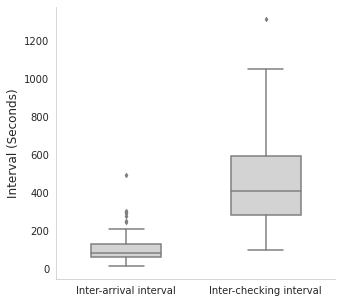

In [ ]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(5, 5))

ax=sns.boxplot(x="type", y="interval",data=c, width=0.5, color="lightgray", fliersize=3)
#plt.setp(ax.lines, color=".1")
plt.xlabel('', fontsize=12)
plt.ylabel('Interval (Seconds)', fontsize=12)
sns.despine(top=True, right= True,left=False, bottom=False) 
plt.show()

## Number of sessions per session type

In [ ]:
a=pd.DataFrame({"session":df_overall['E_ig_per_class']})
a["Session types"]='$E_{ig}$'
b=pd.DataFrame({"session":df_overall['E_nl_per_class']})
b["Session types"]='$E_{nl}$'
c=pd.DataFrame({"session":df_overall['E_nu_per_class']})
c["Session types"]='$E_{nu}$'
d=pd.DataFrame({"session":df_overall['E_uu_per_class']})
d["Session types"]='$E_{uu}$'
e=pd.DataFrame({"session":df_overall['I_uu_per_class']})
e["Session types"]='$I_{uu}$'
f=pd.concat([a,b,c,d,e], axis=0)

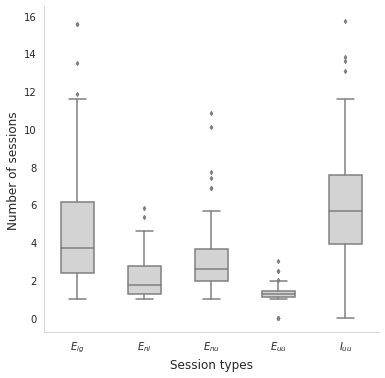

In [ ]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(6, 6))

ax=sns.boxplot(x="Session types", y="session",data=f, width=0.5, color="lightgray", fliersize=3)
#plt.setp(ax.lines, color=".1")
plt.xlabel('Session types', fontsize=12)
plt.ylabel('Number of sessions', fontsize=12)
sns.despine(top=True, right= True,left=False, bottom=False) 
plt.show()